In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import numpy as np
import os
import pandas as pd
from glob import glob
import functions as f
#import climpredNEW.climpred 
#from climpredNEW.climpred.options import OPTIONS
from climpred.options import OPTIONS
import climpred
import pickle
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import itertools
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
from scipy.stats import rankdata
import bottleneck as bn
import scipy.stats as stats
import pickle



2024-01-06 10:17:56.892534: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-06 10:17:59.457170: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 10:18:04.336820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook imp

In [2]:
#Set script parameters

CONUS_mask = f.load_CONUS_mask() #Mask of CONUS which serves as our bounding box. Can later change this to a larger file but then we would have to edit the data from the previous scripts. 
start_obs = '2000-01-01' #Beginning of observation period for analysis. We actually have data starting from 1999 so that we could have a 7-day rolling mean applied to the data and have up to 12 weeks lags for RZSM
end_obs = '2020-12-31' #end of observations for ERA5 and GLEAM. We actually needed data through 2020-02-15 since we have an initialization on 2019-12-25
start_testing = '2018-01-01' #Beginning of testing period
train_end_string = '2015-12-30' #last string date for training
train_end = 2015 #last year of training dates


global RZSM_or_Tmax_or_both
RZSM_or_Tmax_or_both = 'RZSM' # for getting the predictor from either RZSM and Tmax ('both') or only RZSM ('RZSM')


In [3]:
#Load GLEAM anomaly data
anomaly_obs = xr.open_dataset('Data/GLEAM/RZSM_anomaly.nc')

# Convert xarray dataset to pandas DataFrame
df = anomaly_obs.to_dataframe(dim_order=['time', 'latitude', 'longitude']).reset_index()


In [73]:
def autocorrelation_by_lag(lag,anomaly_obs):
    
    #Save location
    save_name = f'Data/GLEAM/autocorrelation_lag{lag:02}.nc'
    
    out_arr = np.zeros(shape=(anomaly_obs.latitude.shape[0], anomaly_obs.longitude.shape[0]))
    
    out_nc = anomaly_obs.isel(time=0)
    
    all_values = anomaly_obs.RZSM.values
    
    for lat in range(out_arr.shape[0]):
        for lon in range(out_arr.shape[1]):
            
            data_df = pd.Series(all_values[:,lat,lon])
            auto_corr = data_df.autocorr(lag=lag)
            out_arr[lat,lon] = auto_corr
    
    out_nc.RZSM[:,:] = out_arr
    out_nc = out_nc.rename({'RZSM':'RZSM_autocorr'})
    out_nc.to_netcdf(save_name)
    
    return('Done')
            

    

In [74]:
for lag in [7,14,21,28,35,42,49,56,63]:
    autocorrelation_by_lag(lag,anomaly_obs)

# Plot autocorrelation values

In [86]:
def get_min_max_of_files(corr_files):
    min_, max_ = [], []
    for file in corr_files:
        min_.append(xr.open_dataset(file).min().RZSM_autocorr.values)
        max_.append(xr.open_dataset(file).max().RZSM_autocorr.values)
    
    return(min(min_),max(max_))


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Pleas

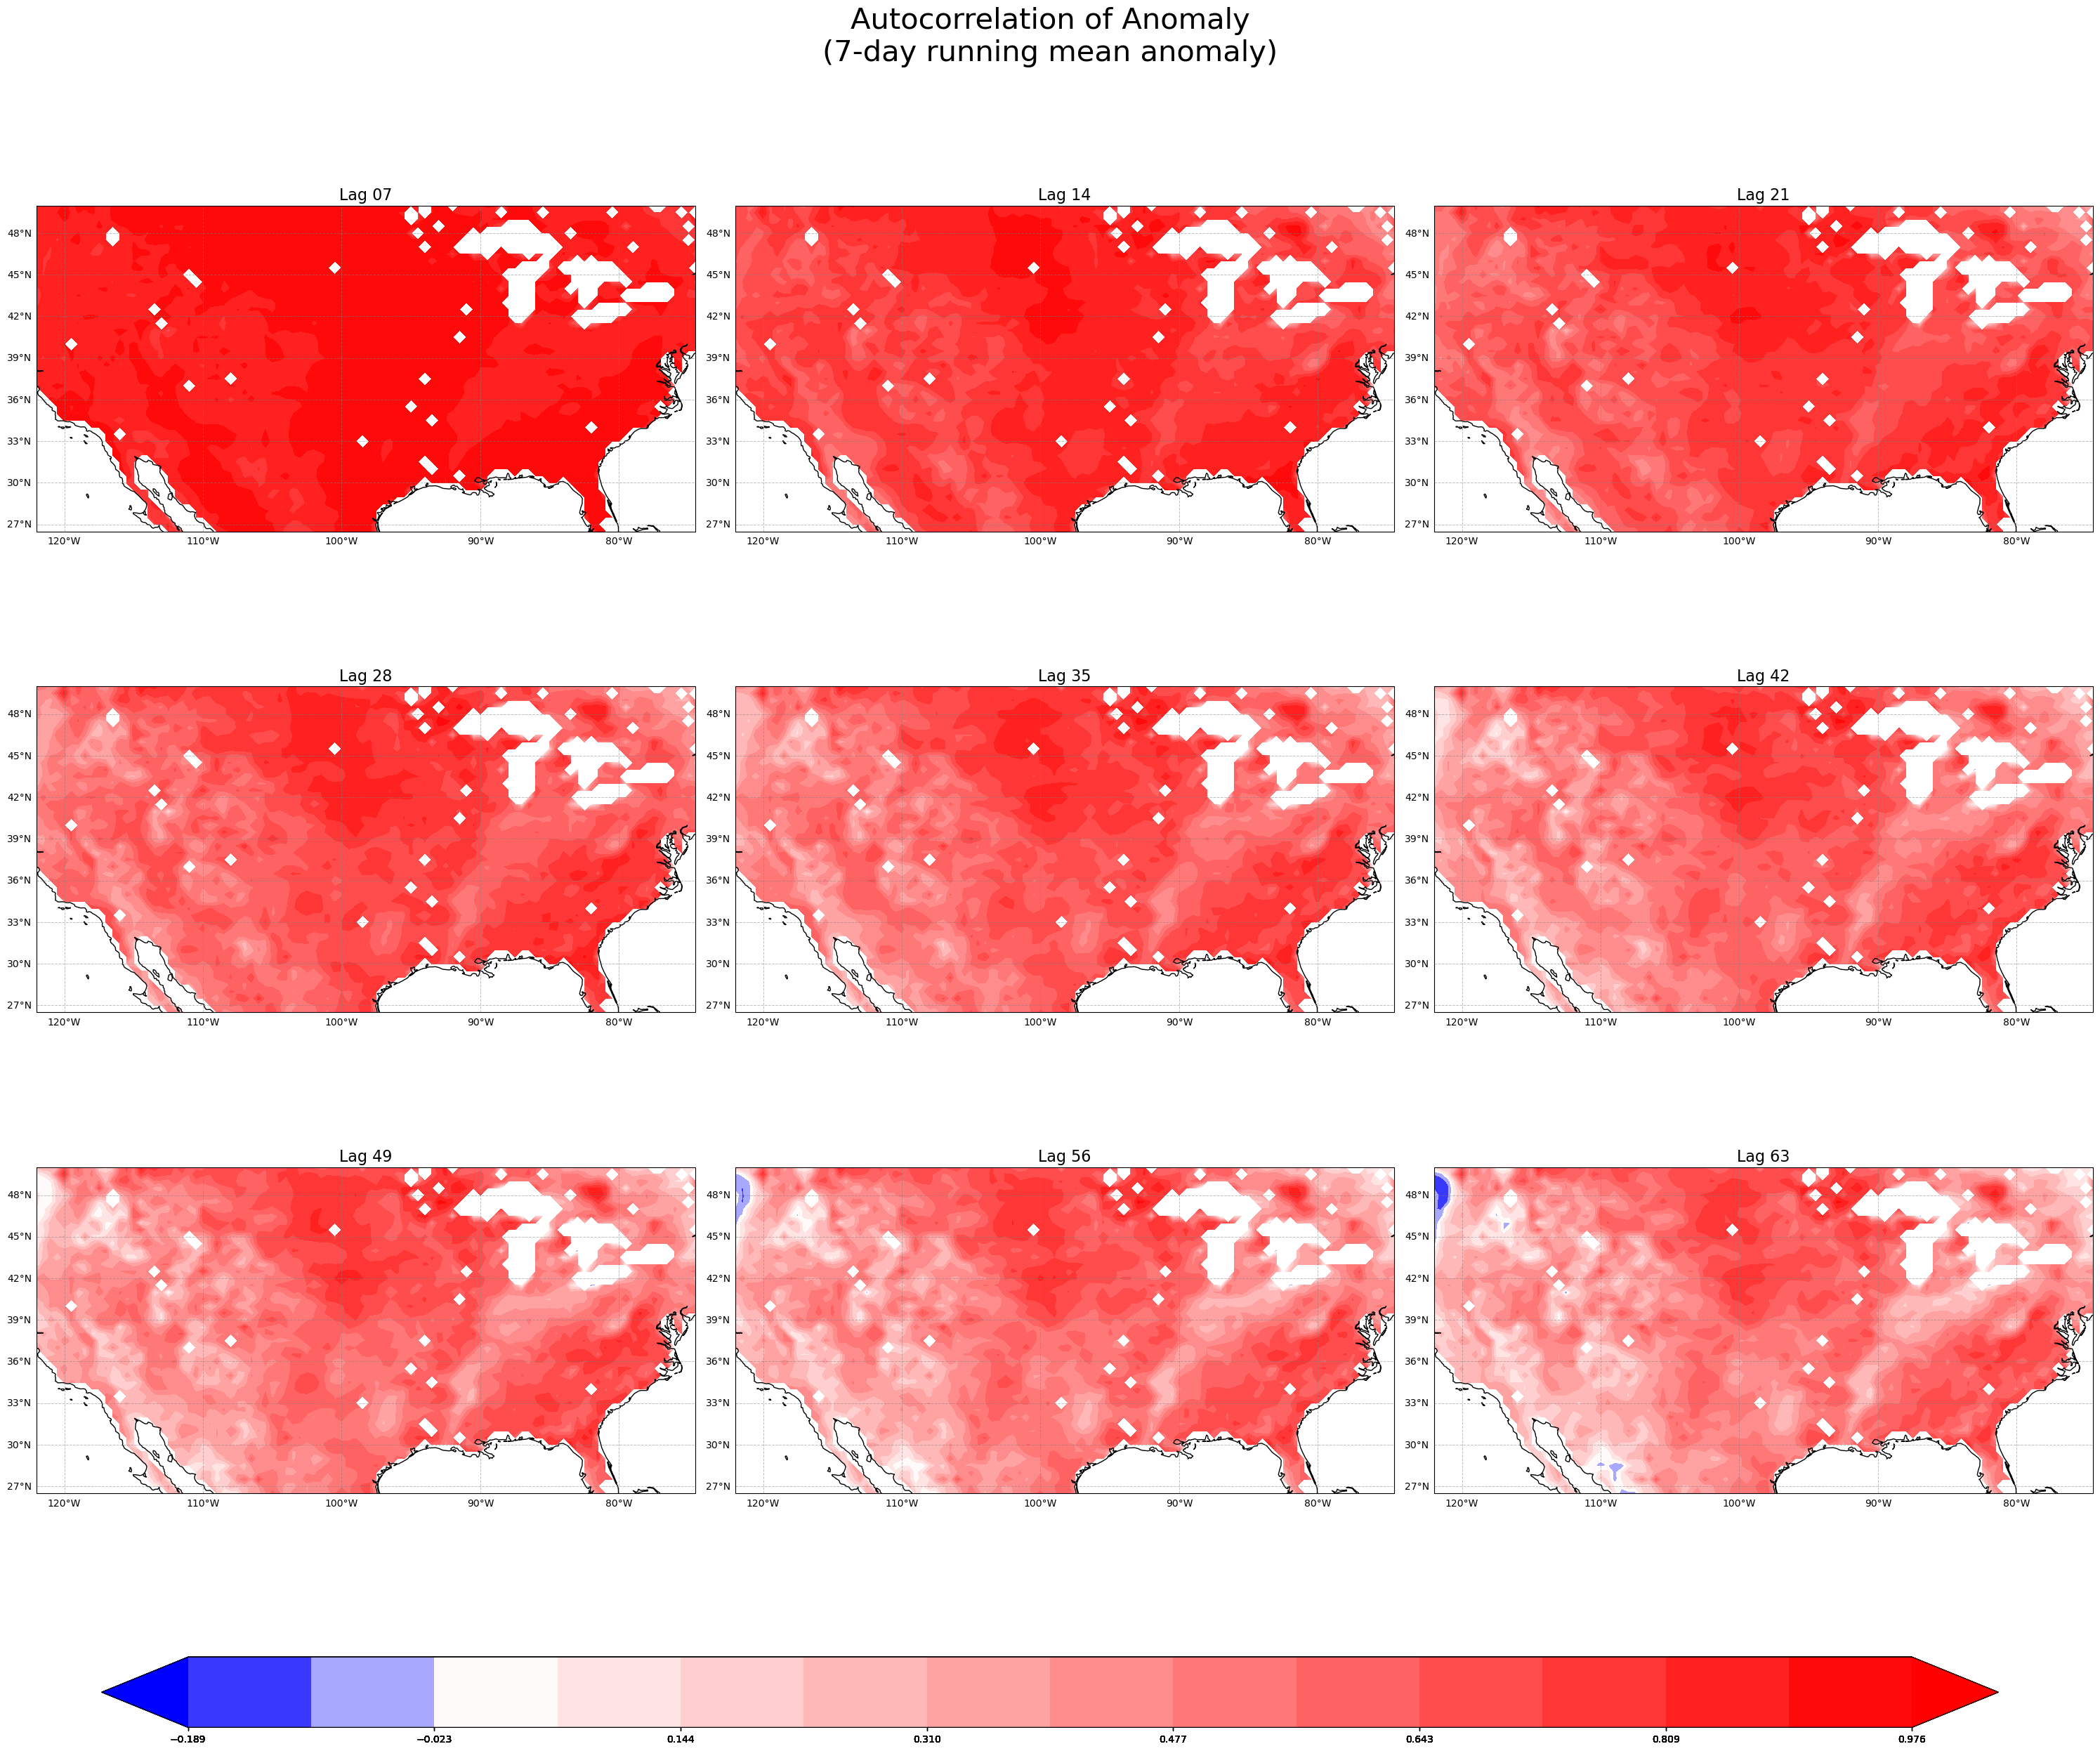

In [122]:

cmap = plt.get_cmap('bwr')    

save_dir = f'Outputs/autocorrelation_GLEAM'
os.system(f'mkdir -p {save_dir}')

corr_files = sorted(glob('Data/GLEAM/autocorre*'))
total_corr_files = len(corr_files)

# if lead == 0:
#     row=3
#     column=5
#     width = 20
#     height=10
#     ex_size = 12
# else:
#     row=6
#     column=5
#     width = 30
#     height=25
#     ex_size = 16

width = 30
height=25
ex_size = 16

fig, axs = plt.subplots(
    3, 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(width, height))
axs = axs.flatten()
fig.tight_layout()

min_,max_ = get_min_max_of_files(corr_files)
# test_file = mae_rzsm_keys
# for Subx original data

# #For the ACC values
# if lead == 0:
#     text_x = -84  # You may need to adjust this value based on your data
#     text_y = 27  # You may need to adjust this value based on your data
#     font_size = 12
# else:
#     text_x = -84  # You may need to adjust this value based on your data
#     text_y = 27  # You may need to adjust this value based on your data
#     font_size = 16

for idx,experiment in enumerate(corr_files):
    op_file = xr.open_dataset(experiment)
    lon = op_file.longitude.values
    lat = op_file.latitude.values  
    data = op_file.RZSM_autocorr.values
    
    lag_name = experiment.split('_')[-1].split('.')[0][3:]
    
    v = np.linspace(min_, max_, 15, endpoint=True)

    map = Basemap(projection='cyl', llcrnrlat=25, urcrnrlat=50,
                  llcrnrlon=-128, urcrnrlon=-60, resolution='l')
    x, y = map(*np.meshgrid(lon, lat))
    # Adjust the text coordinates based on the actual data coordinates

    # ax.drawmeridians()
    try:
        norm = TwoSlopeNorm(vmin=min_, vcenter=0, vmax=max_)
    except ValueError:
        norm = None


    im = axs[idx].contourf(x, y, data, levels=v, extend='both',
                          transform=ccrs.PlateCarree(), cmap=cmap,norm=norm)



    # axs[idx].title.set_text(f'Lag {lag_name}')
    gl = axs[idx].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                               linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    axs[idx].coastlines()
    # plt.colorbar(im)
    # axs[idx].set_aspect('auto', adjustable=None)
    axs[idx].set_aspect('equal')  # this makes the plots better
    axs[idx].set_title(f'Lag {lag_name}',fontsize=ex_size)
    # axs[idx].text(text_x, text_y, mean_vals, ha='right', va='bottom', fontsize=font_size, color='blue', weight = 'bold')


    # Add a colorbar axis at the bottom of the graph
    # left, bottom, width, height
    cbar_ax = fig.add_axes([0.05, 0.0, .9, .04])
    # Draw the colorbar
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    
    
    
plt.tight_layout()   
fig.suptitle('Autocorrelation of Anomaly\n(7-day running mean anomaly)', fontsize=30)
plt.savefig(f'{save_dir}/Autocorrelation.png',bbox_inches='tight')
plt.show()
